# Предсказание курительного статуса пациента

## Задача
Бинарная классификация для предсказания курительного статуса пациента на основе показателей здоровья.

## Метрика оценки
ROC-AUC (площадь под ROC-кривой)

## Структура решения
1. **EDA** - детальный анализ данных
2. **Предобработка** - обработка пропусков, выбросов, масштабирование
3. **Генерация признаков** - создание новых фич
4. **Бейслайн** - сильная модель (градиентный бустинг)
5. **Усиления**:
   - Расширенная генерация признаков
   - Регуляризация
   - Feature Jittering
   - Label Smoothing
   - Ансамблирование (блендинг, стекинг, voting)
   - Pseudo-labeling


In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#warnings.filterwarnings('ignore') этот выстрел в ногу мы сделаем позже

# Машинное обучение
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# Градиентный бустинг
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Для ансамблирования
from sklearn.model_selection import KFold

# Настройка визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("Библиотеки успешно импортированы!")


Библиотеки успешно импортированы!


In [2]:
# Загрузка данных для локалки
train = pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e24/sample_submission.csv')

print(f"Размер обучающей выборки: {train.shape}")
print(f"Размер тестовой выборки: {test.shape}")
print(f"\nПервые строки обучающей выборки:")
train.head()


Размер обучающей выборки: (159256, 24)
Размер тестовой выборки: (106171, 23)

Первые строки обучающей выборки:


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [3]:
# Загрузка данных для локалки
#train = pd.read_csv('playground-series-s3e24/train.csv')
#test = pd.read_csv('playground-series-s3e24/test.csv')
#sample_submission = pd.read_csv('playground-series-s3e24/sample_submission.csv')

print(f"Размер обучающей выборки: {train.shape}")
print(f"Размер тестовой выборки: {test.shape}")
print(f"\nПервые строки обучающей выборки:")
train.head()


Размер обучающей выборки: (159256, 24)
Размер тестовой выборки: (106171, 23)

Первые строки обучающей выборки:


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


## 1. Exploratory Data Analysis (EDA)

### 1.1 Базовая информация о данных


In [4]:
# Базовая информация о данных
print("=" * 60)
print("ИНФОРМАЦИЯ О ДАННЫХ")
print("=" * 60)
print(f"\nКолонки обучающей выборки:\n{train.columns.tolist()}")
print(f"\nТипы данных:\n{train.dtypes}")
print(f"\nПропущенные значения:\n{train.isnull().sum().sum()}")
print(f"\nДубликаты: {train.duplicated().sum()}")
print(f"\nРаспределение целевой переменной:")
print(train['smoking'].value_counts())
print(f"\nПроцент курящих: {train['smoking'].mean()*100:.2f}%")


ИНФОРМАЦИЯ О ДАННЫХ

Колонки обучающей выборки:
['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'smoking']

Типы данных:
id                       int64
age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)            int64
hearing(right)           int64
systolic                 int64
relaxation               int64
fasting blood sugar      int64
Cholesterol              int64
triglyceride             int64
HDL                      int64
LDL                      int64
hemoglobin             float64
Urine protein            int64
serum creatinine       float64
AST                      int

In [5]:
# Статистическое описание числовых признаков
print("Статистическое описание числовых признаков:")
train.describe()


Статистическое описание числовых признаков:


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,...,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,79627.500000,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,...,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365
std,45973.391572,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,...,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,...,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,39813.750000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,...,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,79627.500000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,119441.250000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,...,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,159255.000000,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,...,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000


### 1.2 Визуализация распределения целевой переменной


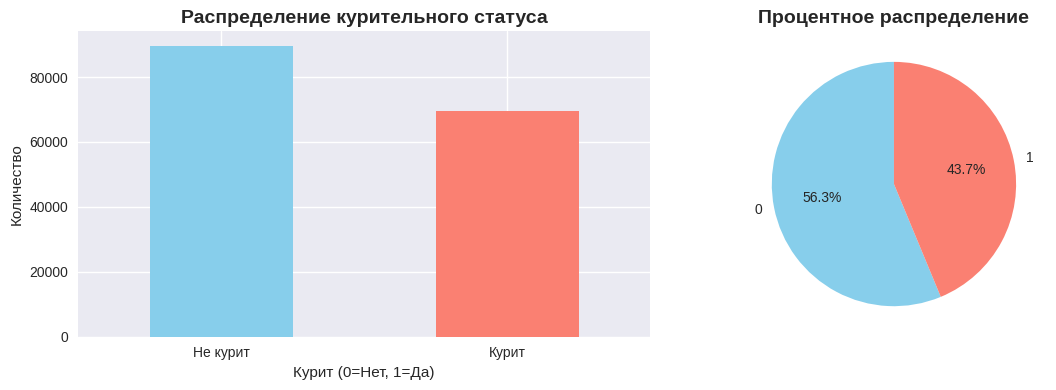

Баланс классов: {0: 89603, 1: 69653}


In [6]:
# Визуализация распределения целевой переменной
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Столбчатая диаграмма
train['smoking'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Распределение курительного статуса', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Курит (0=Нет, 1=Да)')
axes[0].set_ylabel('Количество')
axes[0].set_xticklabels(['Не курит', 'Курит'], rotation=0)

# Круговая диаграмма
train['smoking'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                      colors=['skyblue', 'salmon'], startangle=90)
axes[1].set_title('Процентное распределение', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(f"Баланс классов: {train['smoking'].value_counts().to_dict()}")


### 1.3 Анализ пропущенных значений


In [7]:
# Анализ пропущенных значений
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()

if missing_train.sum() > 0 or missing_test.sum() > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    missing_train[missing_train > 0].plot(kind='barh', ax=axes[0], color='coral')
    axes[0].set_title('Пропущенные значения в обучающей выборке', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Количество пропусков')
    
    missing_test[missing_test > 0].plot(kind='barh', ax=axes[1], color='lightblue')
    axes[1].set_title('Пропущенные значения в тестовой выборке', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Количество пропусков')
    
    plt.tight_layout()
    plt.show()
    
    print("Пропущенные значения в train:")
    print(missing_train[missing_train > 0])
    print("\nПропущенные значения в test:")
    print(missing_test[missing_test > 0])
else:
    print("✓ Пропущенных значений не обнаружено!")


✓ Пропущенных значений не обнаружено!


### 1.4 Анализ распределения признаков и выбросов


Количество числовых признаков: 22
Признаки: ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']


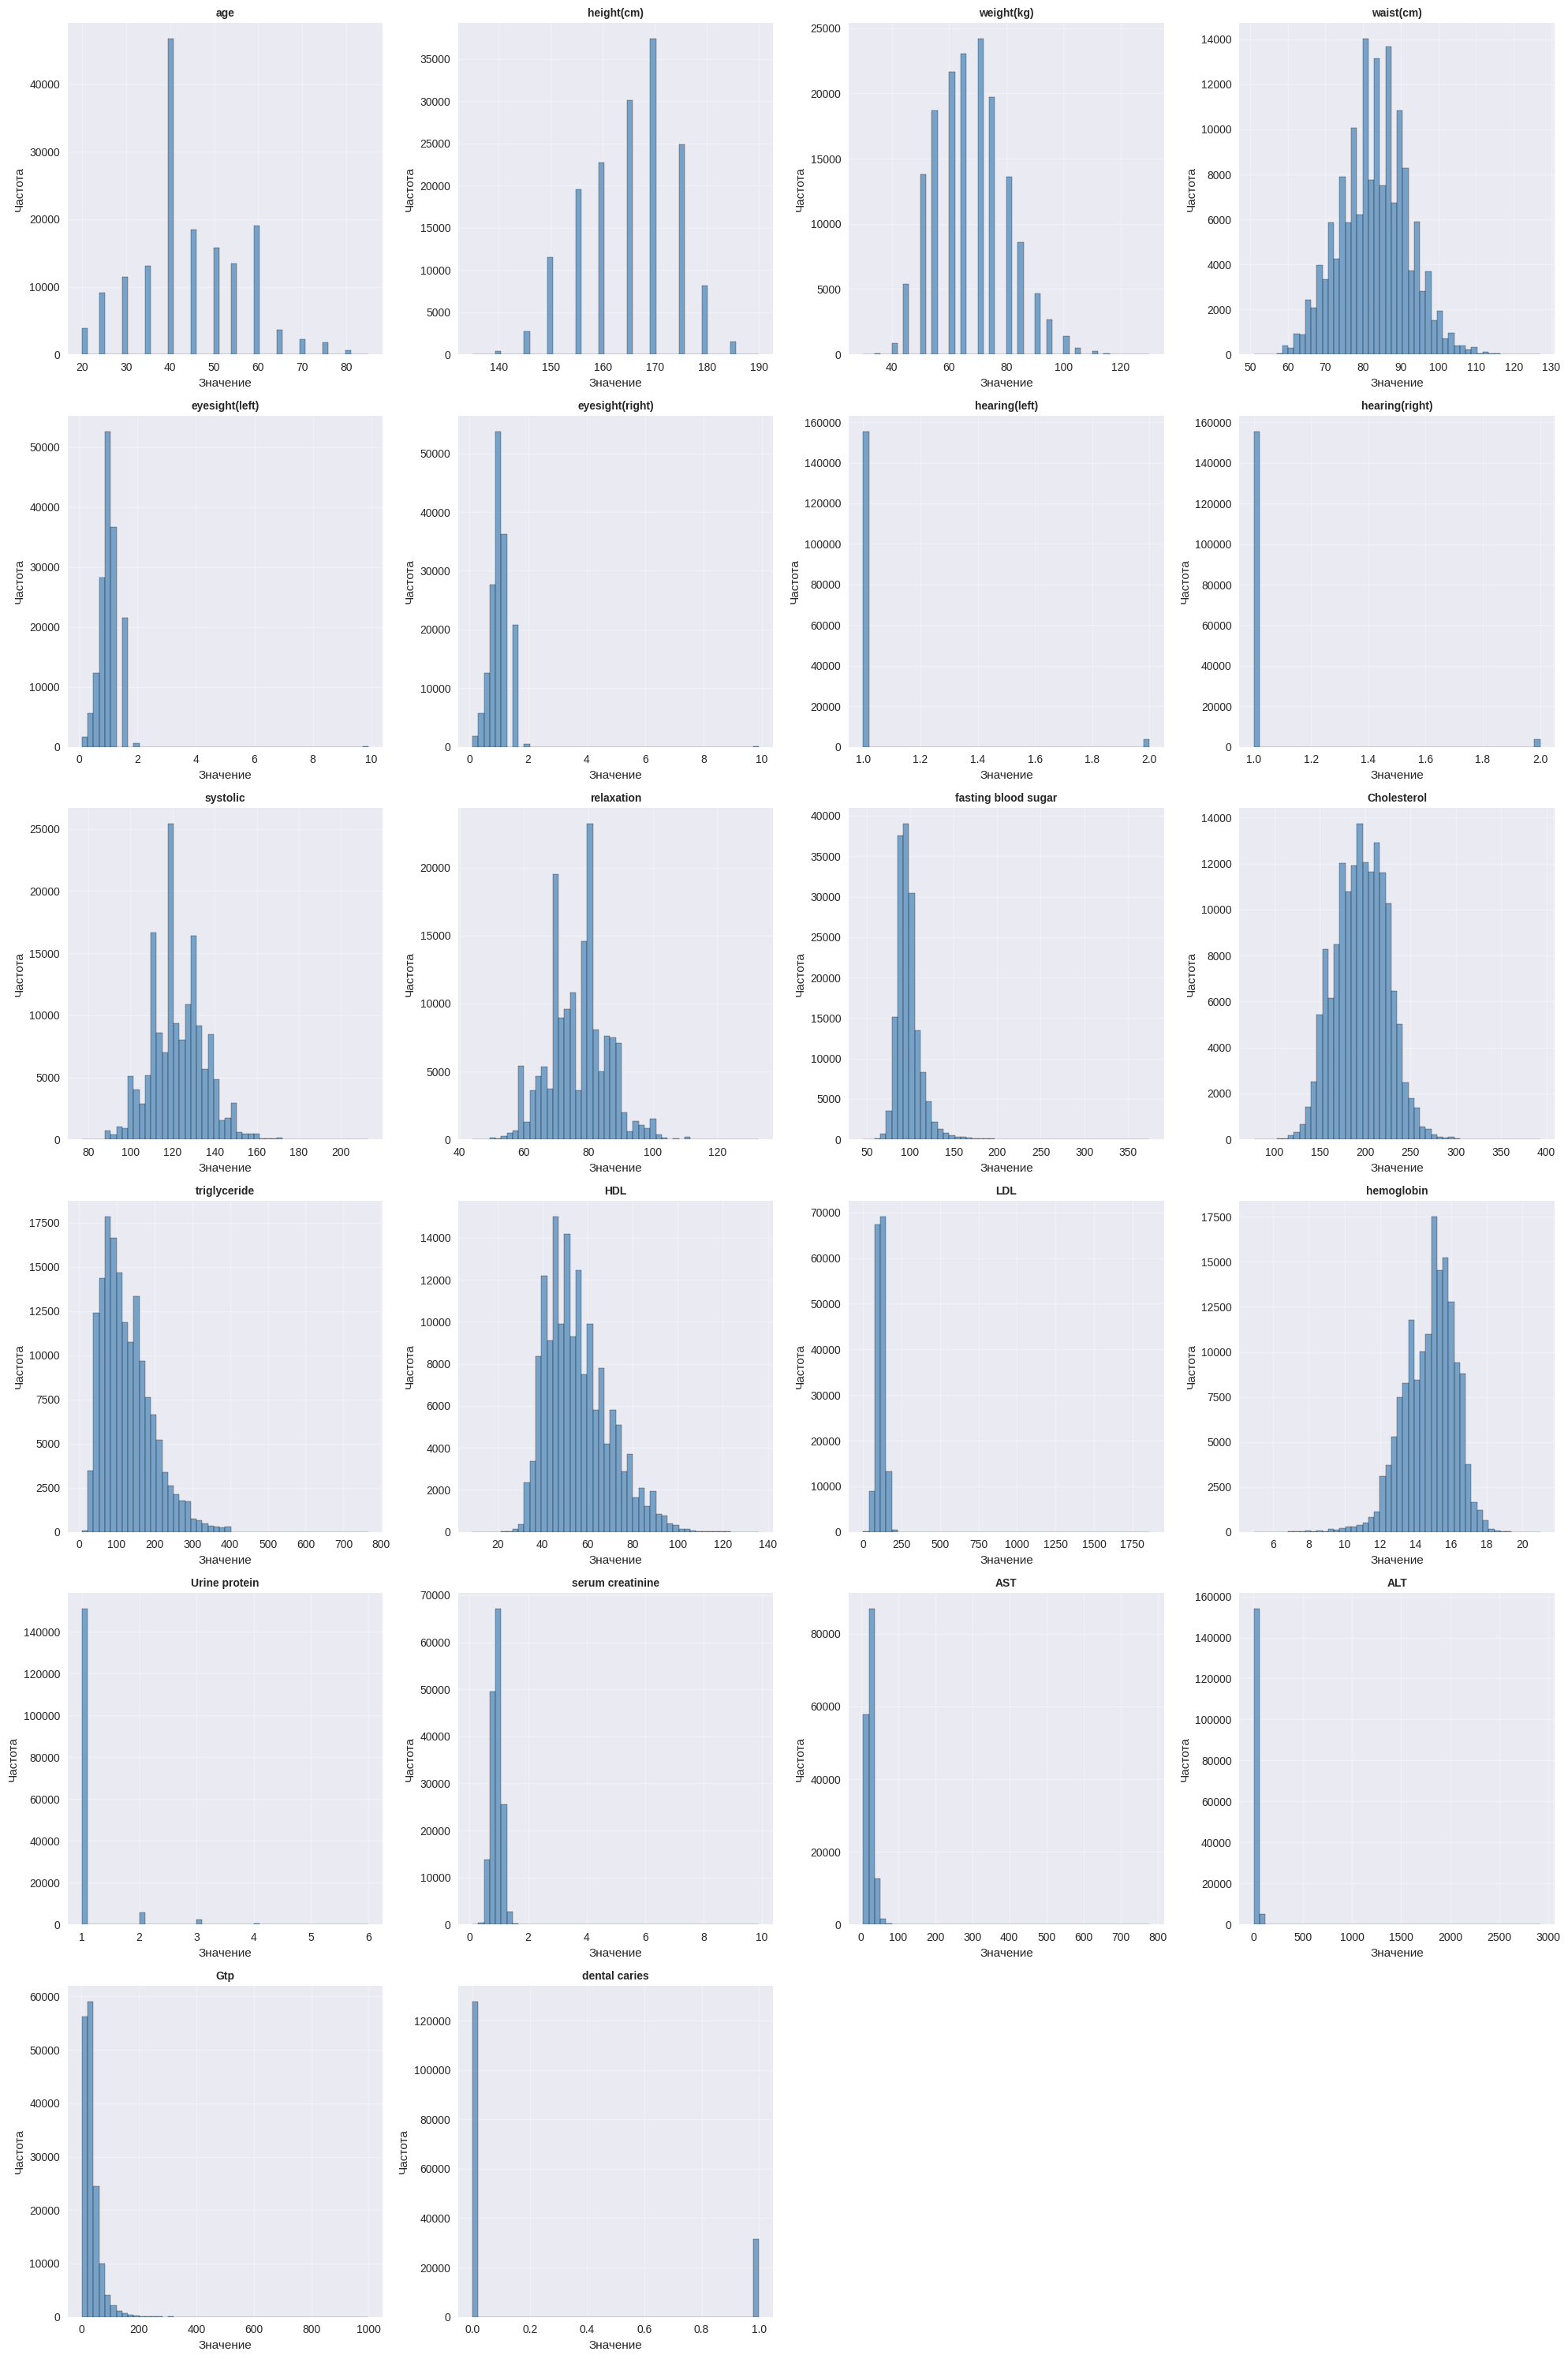

In [8]:
# Выделение числовых признаков (исключаем id и целевую переменную)
numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [f for f in numeric_features if f not in ['id', 'smoking']]

print(f"Количество числовых признаков: {len(numeric_features)}")
print(f"Признаки: {numeric_features}")

# Визуализация распределения признаков
n_cols = 4
n_rows = (len(numeric_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(numeric_features):
    train[feature].hist(bins=50, ax=axes[idx], alpha=0.7, color='steelblue', edgecolor='black')
    axes[idx].set_title(f'{feature}', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Значение')
    axes[idx].set_ylabel('Частота')
    axes[idx].grid(True, alpha=0.3)

# Скрываем лишние subplot'ы
for idx in range(len(numeric_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


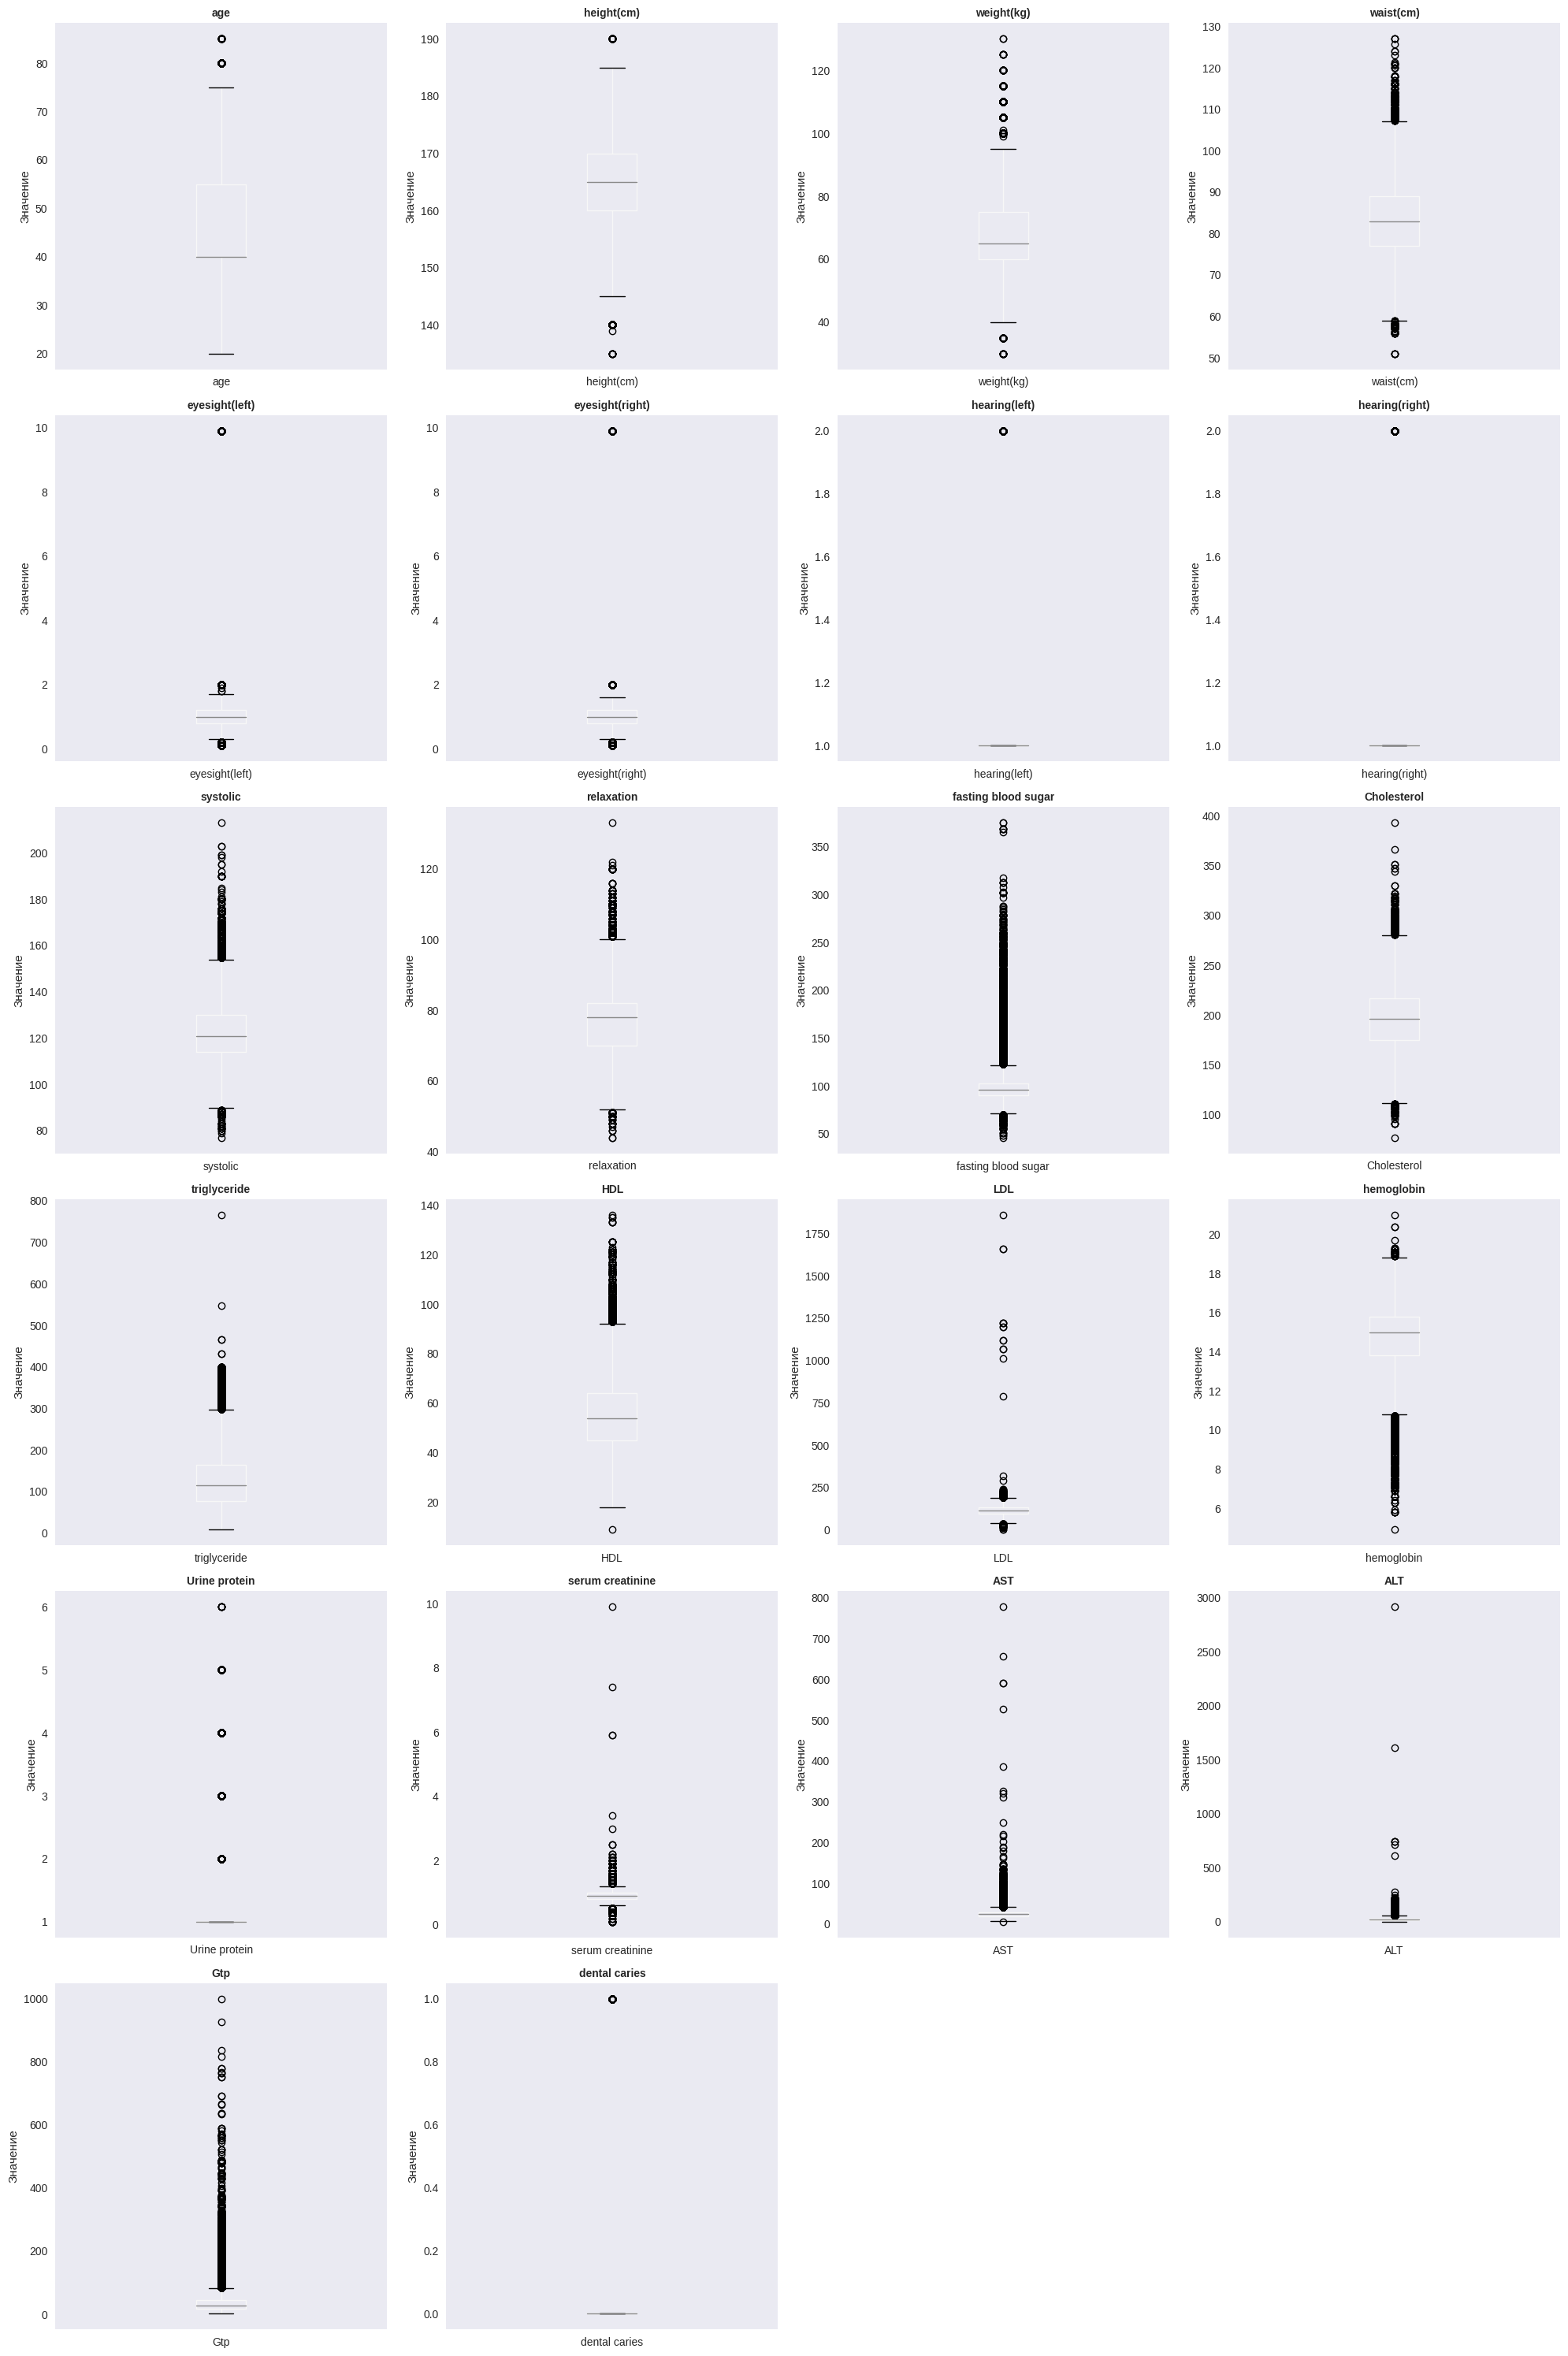

In [9]:
# Box plots для выявления выбросов
n_cols = 4
n_rows = (len(numeric_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(numeric_features):
    train.boxplot(column=feature, ax=axes[idx], grid=False)
    axes[idx].set_title(f'{feature}', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Значение')

for idx in range(len(numeric_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


### 1.5 Корреляционный анализ


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


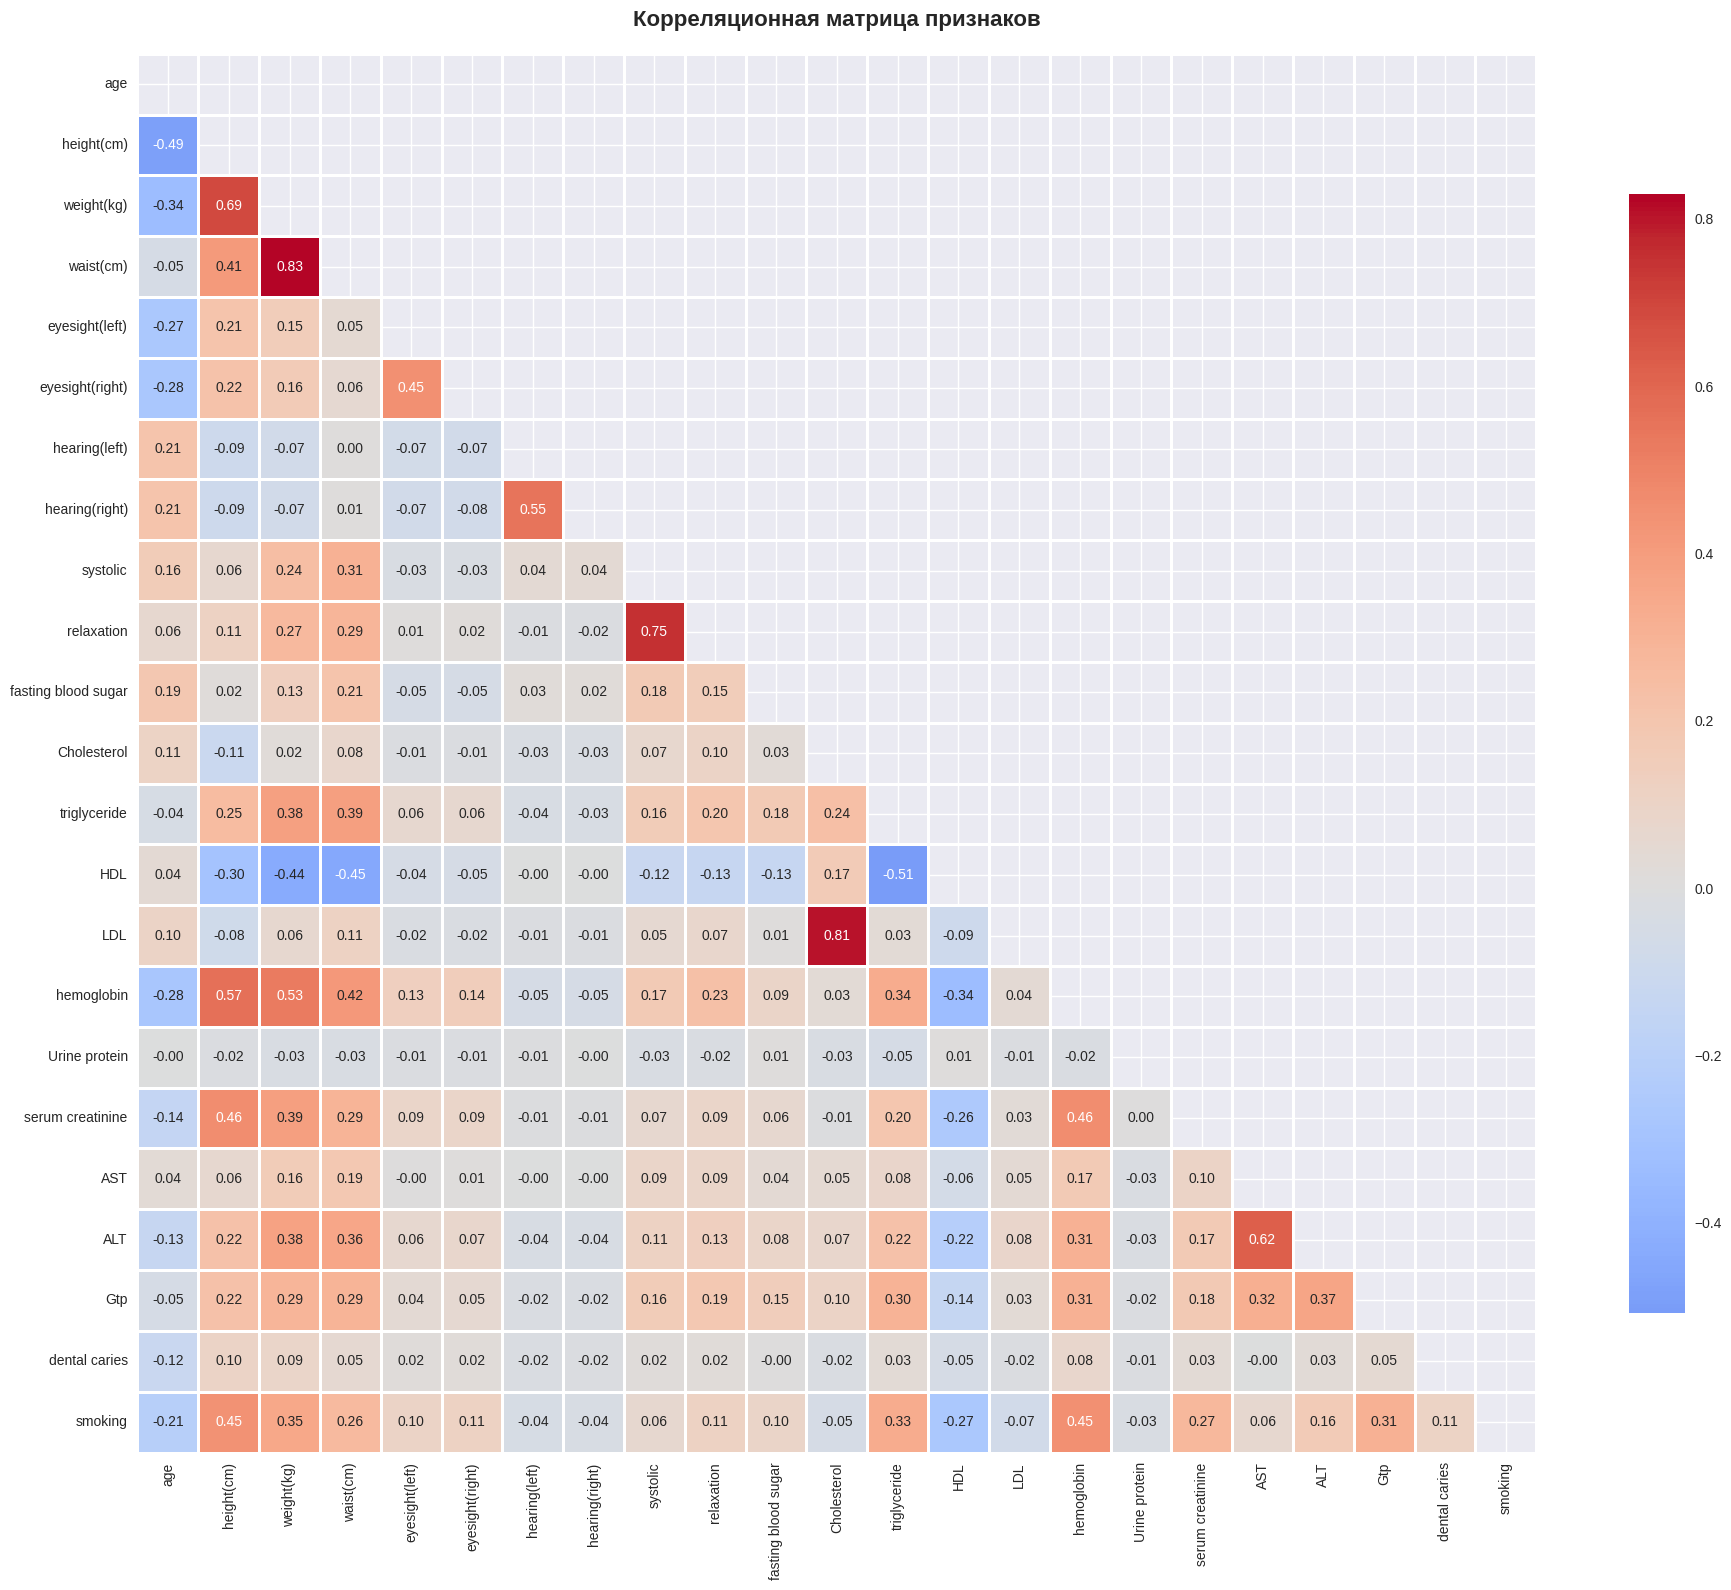

Корреляции признаков с целевой переменной:
smoking                1.000000
hemoglobin             0.450679
height(cm)             0.447111
weight(kg)             0.351748
triglyceride           0.331975
Gtp                    0.305561
serum creatinine       0.272979
waist(cm)              0.262715
ALT                    0.163016
eyesight(right)        0.109781
relaxation             0.109501
dental caries          0.106636
eyesight(left)         0.100420
fasting blood sugar    0.096534
AST                    0.059394
systolic               0.058642
Urine protein         -0.028548
hearing(right)        -0.036858
hearing(left)         -0.038219
Cholesterol           -0.051896
LDL                   -0.072285
age                   -0.206033
HDL                   -0.271186
Name: smoking, dtype: float64


In [10]:
# Корреляционная матрица
correlation_matrix = train[numeric_features + ['smoking']].corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица признаков', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Корреляции с целевой переменной
correlations_with_target = correlation_matrix['smoking'].sort_values(ascending=False)
print("Корреляции признаков с целевой переменной:")
print(correlations_with_target)


### 1.6 Анализ различий между классами


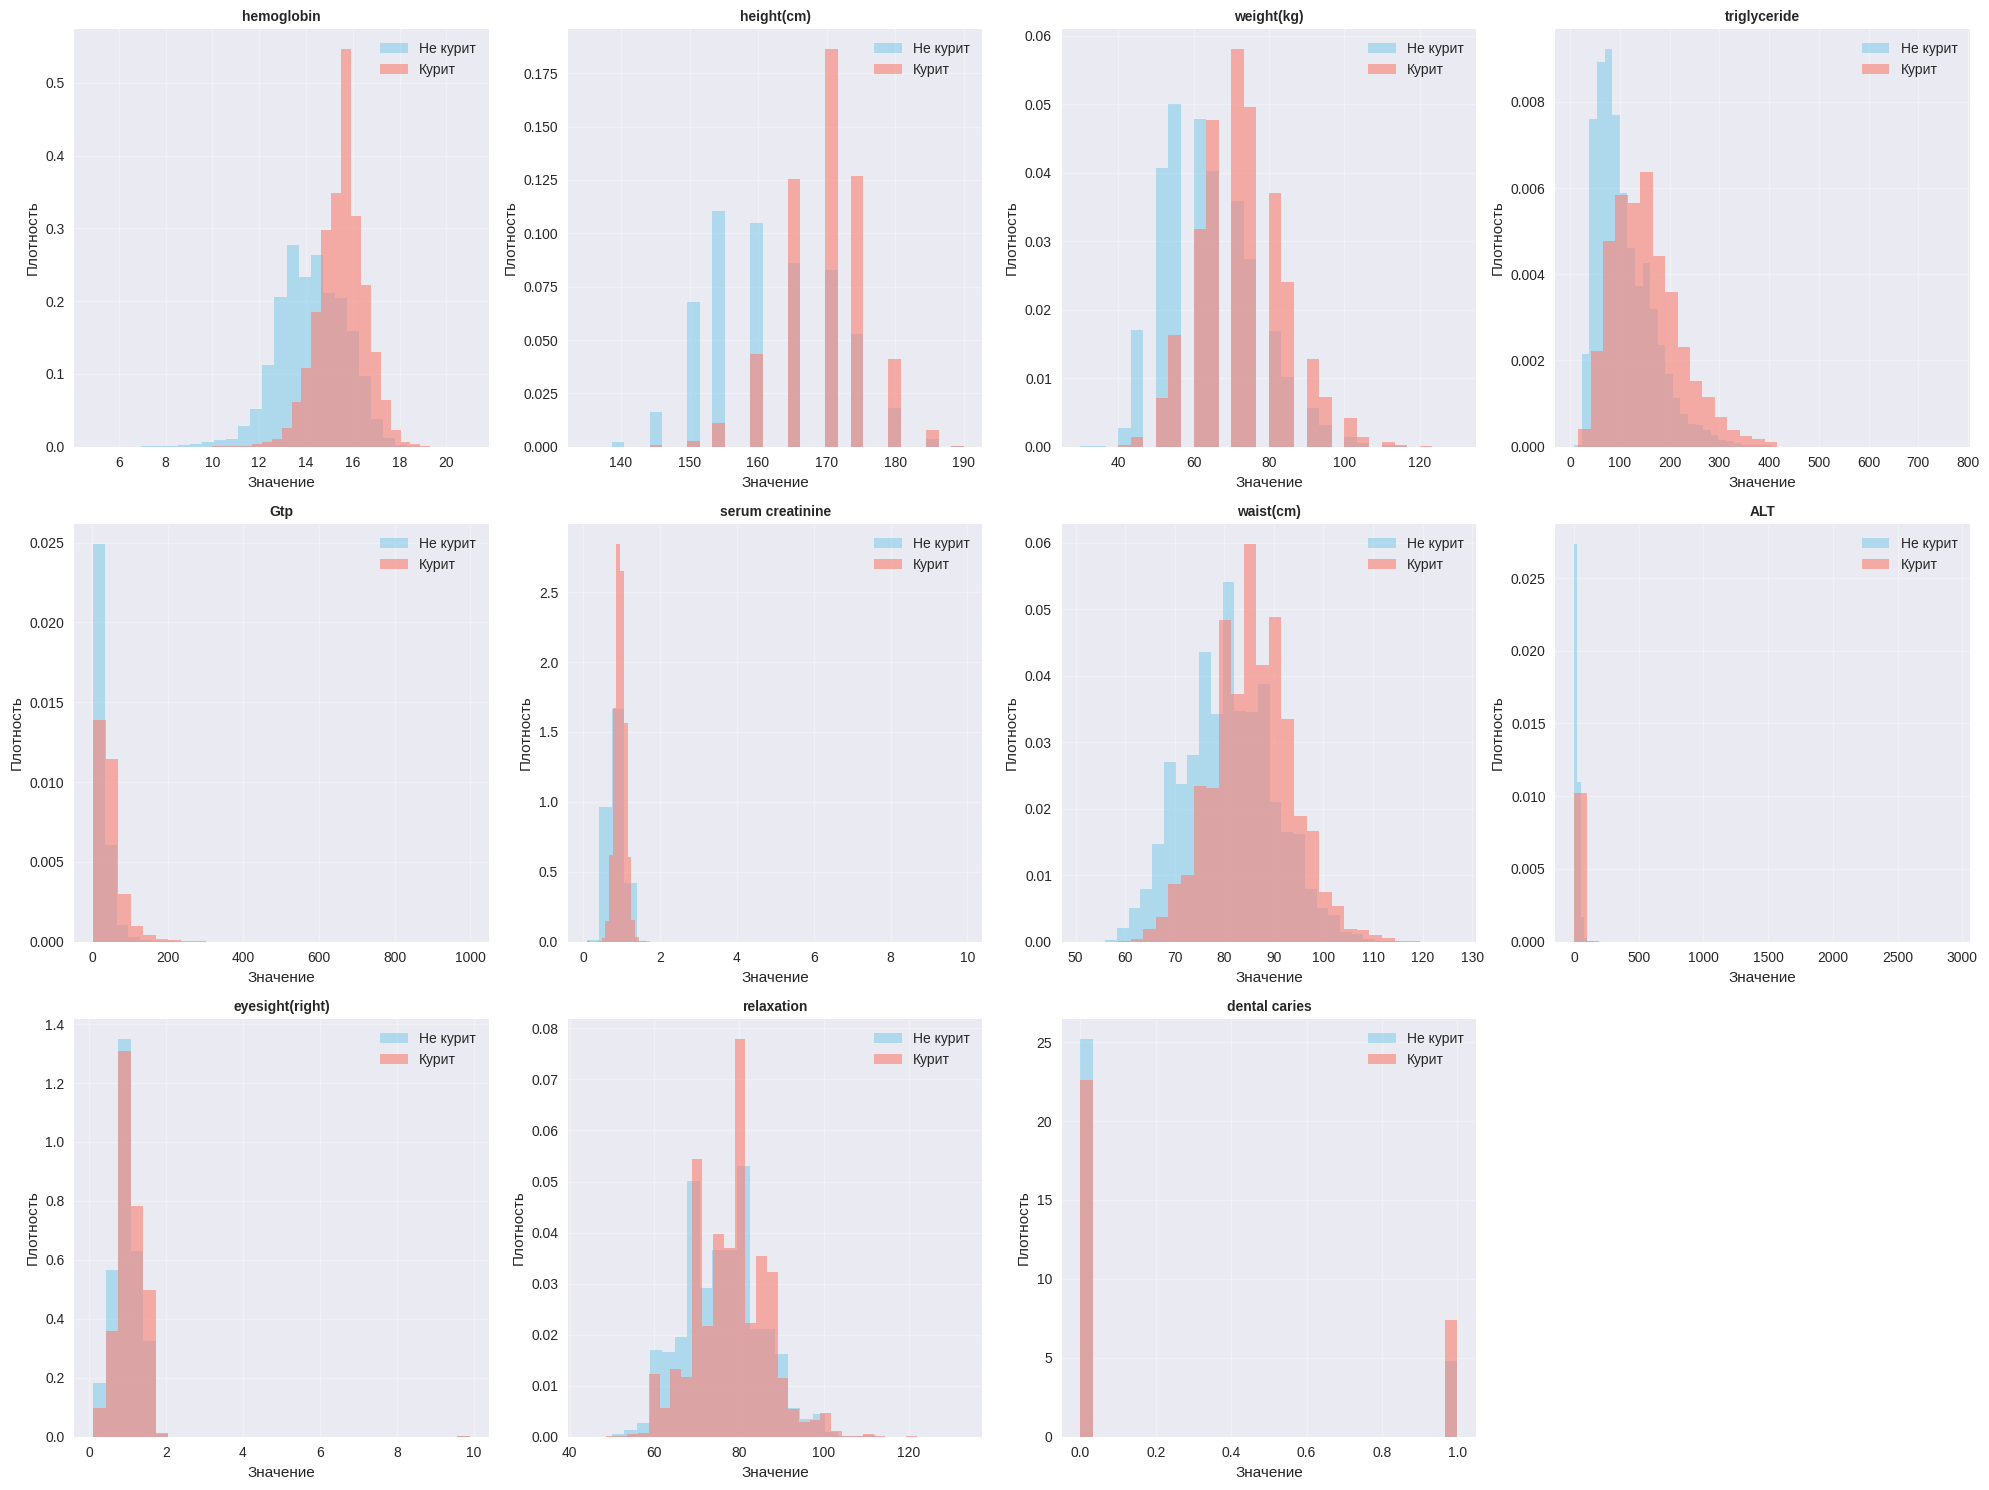

In [11]:
# Сравнение распределений признаков для курящих и некурящих
top_features = correlations_with_target.abs().head(12).index.tolist()
top_features = [f for f in top_features if f != 'smoking']

n_cols = 4
n_rows = (len(top_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    train[train['smoking'] == 0][feature].hist(bins=30, ax=axes[idx], alpha=0.6, 
                                               label='Не курит', color='skyblue', density=True)
    train[train['smoking'] == 1][feature].hist(bins=30, ax=axes[idx], alpha=0.6, 
                                               label='Курит', color='salmon', density=True)
    axes[idx].set_title(f'{feature}', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Значение')
    axes[idx].set_ylabel('Плотность')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

for idx in range(len(top_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


## 2. Предобработка данных

### 2.1 Подготовка данных


In [12]:
# Сохранение id для submission
train_ids = train['id'].copy()
test_ids = test['id'].copy()

# Выделение целевой переменной
y_train = train['smoking'].copy()

# Удаление id и целевой переменной из признаков
X_train = train.drop(['id', 'smoking'], axis=1)
X_test = test.drop(['id'], axis=1)

print(f"Размер X_train: {X_train.shape}")
print(f"Размер X_test: {X_test.shape}")
print(f"Размер y_train: {y_train.shape}")


Размер X_train: (159256, 22)
Размер X_test: (106171, 22)
Размер y_train: (159256,)


### 2.2 Обработка пропущенных значений


In [13]:
# Проверка пропущенных значений
print("Пропущенные значения в X_train:")
print(X_train.isnull().sum().sum())
print("\nПропущенные значения в X_test:")
print(X_test.isnull().sum().sum())

# Заполнение пропусков медианой для числовых признаков
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    if X_train[col].isnull().sum() > 0:
        median_value = X_train[col].median()
        X_train[col].fillna(median_value, inplace=True)
        X_test[col].fillna(median_value, inplace=True)
        print(f"Заполнено пропусков в {col}: {X_train[col].isnull().sum()} -> {median_value}")

# Проверка категориальных признаков
categorical_cols = X_train.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    for col in categorical_cols:
        if X_train[col].isnull().sum() > 0:
            mode_value = X_train[col].mode()[0]
            X_train[col].fillna(mode_value, inplace=True)
            X_test[col].fillna(mode_value, inplace=True)
            print(f"Заполнено пропусков в {col}: {mode_value}")

print("\n✓ Все пропуски обработаны!")


Пропущенные значения в X_train:
0

Пропущенные значения в X_test:
0

✓ Все пропуски обработаны!


### 2.3 Обработка выбросов


In [14]:
def compute_clip_bounds(df, columns, lower_q=0.05, upper_q=0.95):
    """
    Вычисляет границы отсечения на трейне, чтобы затем 
    применять их и к трейну, и к тесту.
    """
    bounds = {}

    for col in columns:
        low = df[col].quantile(lower_q)
        high = df[col].quantile(upper_q)
        # делаем отсуп для сохранения не больших значений крайних квантилей
        res = (1 - upper_q + lower_q) * (high - low) 
        bounds[col] = (low - res, high + res)

    return bounds


def clip_outliers(df, bounds):
    """
    Обрезает значения по заранее рассчитанным границам.
    Границы НЕ пересчитываются, фиксированы.
    """
    df_processed = df.copy()

    for col, (low, high) in bounds.items():
        before = df_processed[col].copy()
        df_processed[col] = df_processed[col].clip(low, high)
        changed = (before != df_processed[col]).sum()

        if changed > 0:
            print(f"{col}: обрезано {changed} значений (границы: [{low:.3f}, {high:.3f}])")

    return df_processed


# === Применение ===

# 1) Считаем границы только по трейну
print("Вычисляем границы по обучающей выборке...")
clip_bounds = compute_clip_bounds(X_train, numeric_cols, lower_q=0.01, upper_q=0.99)

# 2) Применяем одинаковые границы к train
print("\nОбработка выбросов в обучающей выборке:")
X_train = clip_outliers(X_train, clip_bounds)

# 3) Применяем те же границы к test
print("\nОбработка выбросов в тестовой выборке:")
X_test = clip_outliers(X_test, clip_bounds)

print("\n✓ Выбросы обработаны!")


Вычисляем границы по обучающей выборке...

Обработка выбросов в обучающей выборке:
age: обрезано 682 значений (границы: [18.900, 76.100])
height(cm): обрезано 463 значений (границы: [144.200, 185.800])
weight(kg): обрезано 1784 значений (границы: [43.900, 101.100])
waist(cm): обрезано 2623 значений (границы: [62.180, 104.820])
eyesight(left): обрезано 1422 значений (границы: [0.174, 1.526])
eyesight(right): обрезано 1475 значений (границы: [0.174, 1.526])
systolic: обрезано 2471 значений (границы: [93.820, 155.180])
relaxation: обрезано 2348 значений (границы: [58.180, 100.820])
fasting blood sugar: обрезано 2555 значений (границы: [73.440, 154.560])
Cholesterol: обрезано 2617 значений (границы: [133.520, 262.480])
triglyceride: обрезано 1939 значений (границы: [28.100, 334.900])
HDL: обрезано 1716 значений (границы: [31.780, 95.220])
LDL: обрезано 2493 значений (границы: [57.720, 176.280])
hemoglobin: обрезано 2415 значений (границы: [10.766, 17.734])
Urine protein: обрезано 557 значе

### 2.4 Кодирование категориальных признаков


У нас все признаки закодированы числами, можно попробовать их перекодировать умнее, чем labelEncoding, но не уверен, что в этом есть смысл

In [15]:
# Проверка категориальных признаков
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальные признаки: {categorical_cols}")

# Label Encoding для категориальных признаков
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Объединяем train и test для обучения encoder
    combined = pd.concat([X_train[col], X_test[col]], axis=0)
    le.fit(combined)
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le
    print(f"{col}: закодировано {len(le.classes_)} уникальных значений")

print("\n✓ Категориальные признаки закодированы!")


Категориальные признаки: []

✓ Категориальные признаки закодированы!


## 3. Генерация признаков (Feature Engineering)

### 3.1 Базовые признаки


In [16]:
# Функция для генерации признаков
def create_features(df):
    """
    Создание новых признаков на основе существующих.
    """
    df = df.copy()
    
    # BMI (Body Mass Index)
    if 'height(cm)' in df.columns and 'weight(kg)' in df.columns:
        df['BMI'] = df['weight(kg)'] / ((df['height(cm)'] / 100) ** 2)
    
    # Отношение талии к росту (Waist-to-Height Ratio)
    if 'waist(cm)' in df.columns and 'height(cm)' in df.columns:
        df['WHR'] = df['waist(cm)'] / df['height(cm)']
    
    # Среднее зрение
    if 'eyesight(left)' in df.columns and 'eyesight(right)' in df.columns:
        df['eyesight_mean'] = (df['eyesight(left)'] + df['eyesight(right)']) / 2
        df['eyesight_diff'] = abs(df['eyesight(left)'] - df['eyesight(right)'])
    
    # Средний слух
    if 'hearing(left)' in df.columns and 'hearing(right)' in df.columns:
        df['hearing_mean'] = (df['hearing(left)'] + df['hearing(right)']) / 2
        df['hearing_diff'] = abs(df['hearing(left)'] - df['hearing(right)'])
    
    # Пульсовое давление (разница между систолическим и диастолическим)
    if 'systolic' in df.columns and 'relaxation' in df.columns:
        df['pulse_pressure'] = df['systolic'] - df['relaxation']
        df['mean_arterial_pressure'] = df['relaxation'] + (df['pulse_pressure'] / 3)
    
    # Отношения холестерина
    if 'HDL' in df.columns and 'LDL' in df.columns:
        df['HDL_LDL_ratio'] = df['HDL'] / (df['LDL'] + 1e-6)  # +1e-6 для избежания деления на 0
        df['total_cholesterol'] = df['HDL'] + df['LDL'] + (df.get('Cholesterol', 0) / 2)
    
    # Отношение триглицеридов к HDL
    if 'triglyceride' in df.columns and 'HDL' in df.columns:
        df['triglyceride_HDL_ratio'] = df['triglyceride'] / (df['HDL'] + 1e-6)
    
    # Отношение AST к ALT
    if 'AST' in df.columns and 'ALT' in df.columns:
        df['AST_ALT_ratio'] = df['AST'] / (df['ALT'] + 1e-6)
        df['liver_enzymes_sum'] = df['AST'] + df['ALT'] + df.get('Gtp', 0)
    
    # Возрастные группы (может быть полезно для некоторых моделей)
    if 'age' in df.columns:
        df['age_group'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 100], 
                                 labels=[0, 1, 2, 3, 4]).astype(int)
    
    return df

# Применение генерации признаков
print("Генерация признаков для обучающей выборки...")
X_train = create_features(X_train)

print("Генерация признаков для тестовой выборки...")
X_test = create_features(X_test)

print(f"\nНовое количество признаков: {X_train.shape[1]}")
print(f"Новые признаки: {[col for col in X_train.columns if col not in numeric_cols]}")


Генерация признаков для обучающей выборки...
Генерация признаков для тестовой выборки...

Новое количество признаков: 36
Новые признаки: ['BMI', 'WHR', 'eyesight_mean', 'eyesight_diff', 'hearing_mean', 'hearing_diff', 'pulse_pressure', 'mean_arterial_pressure', 'HDL_LDL_ratio', 'total_cholesterol', 'triglyceride_HDL_ratio', 'AST_ALT_ratio', 'liver_enzymes_sum', 'age_group']


### 3.2 Расширенная генерация признаков (x2) - для усиления модели


In [17]:
# Расширенная генерация признаков (полиномиальные, взаимодействия)
def create_advanced_features(df):
    """
    Создание расширенных признаков: полиномиальные, взаимодействия, статистические.
    """
    df = df.copy()
    
    # Полиномиальные признаки для важных переменных
    important_features = ['age', 'BMI', 'systolic', 'relaxation', 'hemoglobin', 
                         'Cholesterol', 'HDL', 'LDL', 'triglyceride']
    
    for feat in important_features:
        if feat in df.columns:
            # Квадрат признака
            df[f'{feat}_squared'] = df[feat] ** 2
            # Квадратный корень
            df[f'{feat}_sqrt'] = np.sqrt(np.abs(df[feat]))
            # Логарифм (для положительных значений)
            if (df[feat] > 0).all():
                df[f'{feat}_log'] = np.log1p(df[feat])
    
    # Взаимодействия между важными признаками
    interactions = [
        ('age', 'BMI'),
        ('age', 'systolic'),
        ('BMI', 'hemoglobin'),
        ('HDL', 'LDL'),
        ('AST', 'ALT'),
        ('systolic', 'relaxation')
    ]
    
    for feat1, feat2 in interactions:
        if feat1 in df.columns and feat2 in df.columns:
            df[f'{feat1}_x_{feat2}'] = df[feat1] * df[feat2]
            df[f'{feat1}_div_{feat2}'] = df[feat1] / (df[feat2] + 1e-6)
    
    # Статистические признаки по группам
    if 'age' in df.columns:
        # Средние значения по возрастным группам
        age_bins = pd.cut(df['age'], bins=5, labels=False)
        for col in ['BMI', 'systolic', 'hemoglobin']:
            if col in df.columns:
                df[f'{col}_age_mean'] = df.groupby(age_bins)[col].transform('mean')
    
    return df

# Применение расширенной генерации признаков
print("Расширенная генерация признаков для обучающей выборки...")
X_train = create_advanced_features(X_train)

print("Расширенная генерация признаков для тестовой выборки...")
X_test = create_advanced_features(X_test)

print(f"\nФинальное количество признаков: {X_train.shape[1]}")
print(f"Общее количество новых признаков: {X_train.shape[1] - len(numeric_cols)}")


Расширенная генерация признаков для обучающей выборки...
Расширенная генерация признаков для тестовой выборки...

Финальное количество признаков: 78
Общее количество новых признаков: 56


### 3.3 Масштабирование признаков


In [18]:
# Масштабирование признаков
scaler = StandardScaler()

# Сохранение названий колонок
feature_names = X_train.columns.tolist()

# Масштабирование
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=feature_names,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=feature_names,
    index=X_test.index
)

print("✓ Признаки масштабированы с помощью StandardScaler")
print(f"Размер X_train_scaled: {X_train_scaled.shape}")
print(f"Размер X_test_scaled: {X_test_scaled.shape}")

# Используем масштабированные данные
X_train = X_train_scaled
X_test = X_test_scaled


✓ Признаки масштабированы с помощью StandardScaler
Размер X_train_scaled: (159256, 78)
Размер X_test_scaled: (106171, 78)


## 4. Бейслайн модель - LightGBM

### Обоснование выбора модели

**LightGBM** выбран как бейслайн по следующим причинам:

1. **Эффективность**: Быстрое обучение и предсказание даже на больших данных
2. **Точность**: Высокая точность на табличных данных благодаря градиентному бустингу
3. **Устойчивость к переобучению**: Встроенная регуляризация и ранняя остановка
4. **Обработка категориальных признаков**: Нативная поддержка категориальных переменных
5. **Интерпретируемость**: Важность признаков легко извлекается
6. **Популярность в соревнованиях**: Часто используется в Kaggle и показывает отличные результаты

**Альтернативы**:
- **XGBoost**: Похожие характеристики, но обычно медленнее
- **CatBoost**: Отличная обработка категориальных признаков, но может быть медленнее
- **Random Forest**: Проще, но обычно менее точный

Для данной задачи бинарной классификации LightGBM является оптимальным выбором.


In [19]:
# Настройка кросс-валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Параметры LightGBM
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42,
    'force_col_wise': True
}

# Кросс-валидация для бейслайна
print("Обучение бейслайн модели LightGBM...")
print("=" * 60)

cv_scores = []
lgb_models = []

# Посчитаем тест baseline
test_preds = np.zeros(len(X_test_scaled))

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Создание датасетов LightGBM
    train_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    # Обучение модели
    model = lgb.train(
        lgb_params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(0)]
    )
    
    # Предсказания
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    score = roc_auc_score(y_val, y_pred)
    cv_scores.append(score)
    lgb_models.append(model)

    # Тестовые предсказания (усредняются)
    test_preds += model.predict(X_test_scaled, num_iteration=model.best_iteration) / skf.n_splits
    
    print(f"Fold {fold + 1}: ROC-AUC = {score:.5f}")

submission = pd.DataFrame({
    "id": test_ids,     
    "smoking": test_preds
})

submission.to_csv("submission.csv", index=False)

print("Файл submission.csv сохранён!")

print("=" * 60)
print(f"Средний ROC-AUC: {np.mean(cv_scores):.5f} (+/- {np.std(cv_scores):.5f})")
print(f"Лучший ROC-AUC: {np.max(cv_scores):.5f}")


Обучение бейслайн модели LightGBM...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[517]	valid_0's auc: 0.865367
Fold 1: ROC-AUC = 0.86537
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[514]	valid_0's auc: 0.868031
Fold 2: ROC-AUC = 0.86803
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[821]	valid_0's auc: 0.867831
Fold 3: ROC-AUC = 0.86783
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[895]	valid_0's auc: 0.865655
Fold 4: ROC-AUC = 0.86565
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[931]	valid_0's auc: 0.867065
Fold 5: ROC-AUC = 0.86706
Файл submission.csv сохранён!
Средний ROC-AUC: 0.86679 (+/- 0.00110)
Лучший ROC-AUC: 0.86803


In [20]:
import os
os.listdir('/kaggle/working')


['__notebook__.ipynb', 'submission.csv']

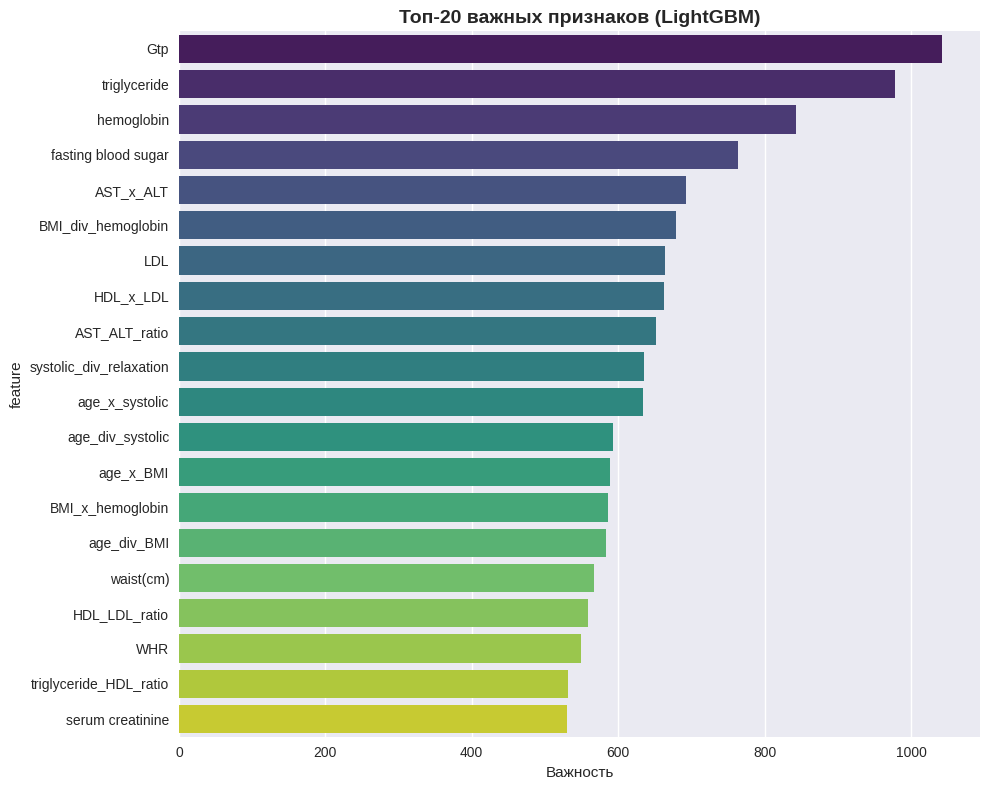

Топ-10 важных признаков:
                    feature  importance
20                      Gtp      1042.2
12             triglyceride       978.2
15               hemoglobin       842.6
10      fasting blood sugar       764.0
71                AST_x_ALT       692.6
68       BMI_div_hemoglobin       678.8
14                      LDL       663.6
69                HDL_x_LDL       662.0
33            AST_ALT_ratio       651.8
74  systolic_div_relaxation       634.8


In [21]:
# Важность признаков для бейслайна
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.mean([model.feature_importance() for model in lgb_models], axis=0)
}).sort_values('importance', ascending=False)

# Визуализация топ-20 важных признаков
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Топ-20 важных признаков (LightGBM)', fontsize=14, fontweight='bold')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

print("Топ-10 важных признаков:")
print(top_features.head(10))
